In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model

Using TensorFlow backend.


## Data Preprocessing

In [0]:
df = pd.read_csv('ml1m_ratings.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

#+1 is the real size, as they are zero based
num_users = df['user_emb_id'].unique().max() + 1
num_movies = df['movie_emb_id'].unique().max() + 1
df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [0]:
train_df, test_df = train_test_split(df,
                                     stratify=df['user_emb_id'],
                                     test_size=0.1,
                                     random_state=999613182)  

In [0]:
train_df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
339280,1997,1018,2,974679219
881301,5322,1293,4,960848231
926190,5597,2293,4,959214335
726548,4344,26,2,966273825
153039,983,3860,3,975115869


In [0]:
train_df, validate_df = train_test_split(train_df,
                                 stratify=train_df['user_emb_id'],
                                 test_size=0.1,
                                 random_state=999613182)  

In [0]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [0]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)

In [0]:
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

## Utility Function

In [0]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [0]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [0]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model
  

In [0]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [0]:
def masked_se(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse

In [0]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [0]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [0]:
def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [0]:
# Test custom cost function
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 10],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])
y_pred = K.constant([[ 1, 1, 1, 3]])
y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [ 0, 1, 1, 1],
                     [ 0, 0, 1, 1],
                     [ 0, 0, 0, 1],
                     [ 0, 0, 0, 0]])
y_true = K.constant([[ 0, 0, 1, 1]])
true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')

[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


## AutoRec

In [0]:
def AutoRec(X, reg, first_activation, last_activation):
    '''
    AutoRec
        INPUT: 
          X: #_user X #_item matrix
          reg: L2 regularization parameter
          first_activation: activation function for first dense layer
          last_activation: activation function for second dense layer
        
        OUTPUT:
          Keras model
    
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [0]:
def AutoRec_LReLU(X, reg):
    '''
    AutoRec
    LReLu is not implemented in to Dense 
    Need to have seperate LeakyRelu layer 
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    x = LeakyReLU()(x)
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [0]:
# Build model

AutoRec = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 3952)              0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate])

In [0]:
plot_model(AutoRec, to_file='AutoRec.png')

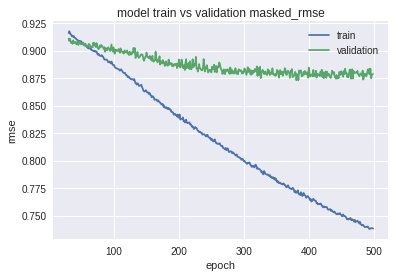

In [0]:
show_rmse(hist_Autorec, 30)

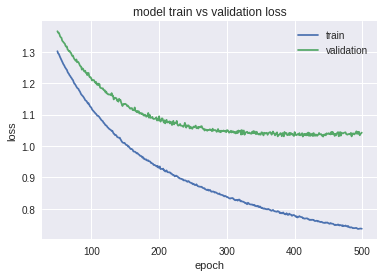

In [0]:
show_error(hist_Autorec, 50)

In [0]:
test_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test)

6040/6040 [==============================] - 1s 135us/sample - loss: 1.0394 - masked_rmse_clip: 0.8810


In [0]:
predict_autorec = AutoRec.predict(users_items_matrix_train_zero)

In [0]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_autorec)))
np.mean(loss)

2.4829845

In [0]:
# model = load_model('AutRec')

Loaded model from disk


In [0]:
# model.compile(optimizer = Adam(lr=0.001), loss=masked_se, metrics=[masked_rmse_clip])
# score = model.evaluate(users_items_matrix_train_zero, users_items_matrix_test)
# score

6040/6040 [==============================] - 2s 253us/sample - loss: 31.5291 - masked_rmse_clip: 0.9159


[31.529148058859718, 0.91590214]

## Deep AE CF

In [0]:
  def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [0]:
layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [0]:
# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 3952)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

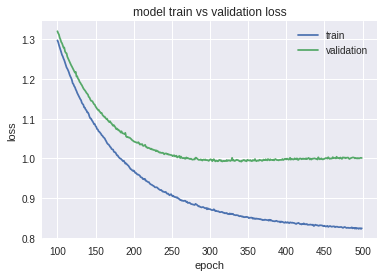

In [0]:
show_error(hist_Deep_AE, 100)

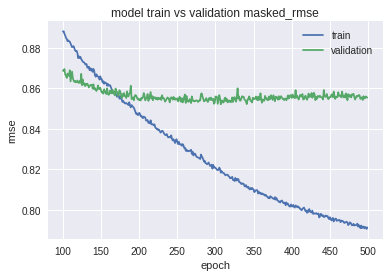

In [0]:
show_rmse(hist_Deep_AE, 100)

In [0]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)

In [0]:
test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

6040/6040 [==============================] - 1s 134us/sample - loss: 1.0004 - masked_rmse_clip: 0.8589


In [0]:
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.7632456

In [0]:
for layer in Deep_AE.layers: 
  print(layer.get_config())

{'batch_input_shape': (None, 3952), 'dtype': 'float32', 'sparse': False, 'name': 'UserRating'}
{'name': 'EncLayer0', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 0.0010000000474974513}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'LatentSpace', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'selu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 0.0010000000474974513}}, 'bias_regular

In [0]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]

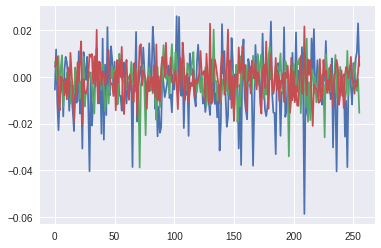

In [0]:
first_layer_weights = Deep_AE.layers[1].get_weights()[0]
plt.plot(np.arange(0, 256, 1), first_layer_weights[0])
plt.plot(np.arange(0, 256, 1), first_layer_weights[1])
plt.plot(np.arange(0, 256, 1), first_layer_weights[2])
plt.show()

## Add Denoise

### Gaussian Noise

#### Gussian AutoRec

In [0]:
## Adding Gaussin noise to input
noise_factor = 0.4
users_items_matrix_train_average_noisy = users_items_matrix_train_average + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 
users_items_matrix_train_zero_noisy = users_items_matrix_train_zero + noise_factor * np.random.normal(size=users_items_matrix_train_zero.shape) 

In [0]:
users_items_matrix_train_average_noisy

array([[4.99900726, 4.30492207, 4.29922036, ..., 4.21125536, 4.19833128,
        4.21537676],
       [3.80915317, 3.6645938 , 3.49922715, ..., 3.88575614, 3.74631529,
        3.63690338],
       [3.79368874, 4.04708265, 3.90333259, ..., 3.72202725, 3.91570177,
        3.81405065],
       ...,
       [3.92870269, 3.63513243, 3.80363898, ..., 3.77111358, 3.95865566,
        4.05883521],
       [3.99251769, 4.06808587, 4.0514266 , ..., 3.95321864, 4.02780201,
        4.01934031],
       [3.6423853 , 3.66484986, 3.57073631, ..., 3.47208484, 3.62669314,
        3.55643493]])

In [0]:
AutoRec = AutoRec(users_items_matrix_train_average_noisy, 0.001, 'elu', 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()

hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average_noisy, users_items_matrix_validate])

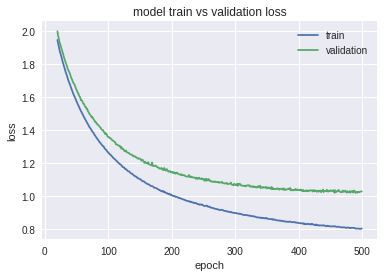

In [0]:
show_error(hist_Autorec, 20)

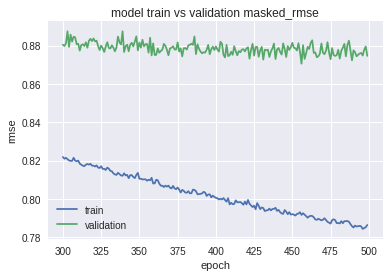

In [0]:
show_rmse(hist_Autorec, 300)

In [0]:
test_result_deep = AutoRec.evaluate(users_items_matrix_train_average_noisy, users_items_matrix_test)

6040/6040 [==============================] - 1s 133us/sample - loss: 1.0258 - masked_rmse_clip: 0.8774


#### Gaussian Deep AE CF

In [0]:
layers = [256, 512, 256]
dropout = 0.8

activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [0]:
# Build model
Deep_AE_denoise = Deep_AE_model(users_items_matrix_train_zero_noisy, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_denoise.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 3952)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1011968   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1015664   
Total params: 2,290,544
Trainable params: 2,290,544
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist_Deep_AE_denoise = Deep_AE_denoise.fit(x=users_items_matrix_train_zero_noisy, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero_noisy, users_items_matrix_validate], verbose=2)

In [0]:
#plot_model(Deep_AE_user, to_file='model.png')

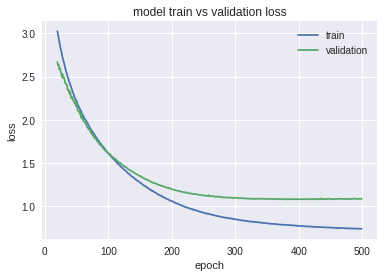

In [0]:
show_error(hist_Deep_AE_denoise, 20)

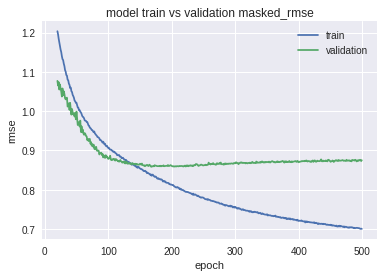

In [0]:
show_rmse(hist_Deep_AE_denoise, 20)

In [0]:
test_result_deep = Deep_AE_denoise.evaluate(users_items_matrix_train_zero_noisy, users_items_matrix_test)

6040/6040 [==============================] - 1s 135us/sample - loss: 1.0798 - masked_rmse_clip: 0.8753


In [0]:
predict_deep = Deep_AE_denoise.predict(users_items_matrix_train_zero_noisy)
loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_deep)))
np.mean(loss)

0.68468785

### Dropout Noise

In [0]:
  def Deep_AE_DropNoise_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, noise):
    '''
    Build Deep AE for CF
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Dropout Noise
    x = Dropout(rate = noise)(x)
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
    # Output

    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [0]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
dropN = 0.1
# Build model
Deep_AE_denoise_dropN = Deep_AE_DropNoise_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, dropN)
Deep_AE_denoise_dropN.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_denoise_dropN.summary()
hist_Deep_AE_denoise_dropN = Deep_AE_denoise_dropN.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

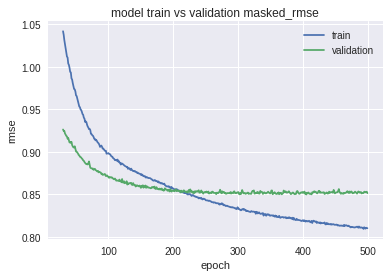

In [0]:
show_rmse(hist_Deep_AE_denoise_dropN, 30)

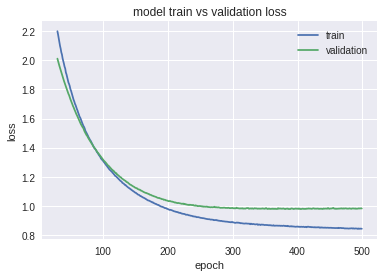

In [0]:
show_error(hist_Deep_AE_denoise_dropN, 30)

In [0]:
test_result_deep = Deep_AE_denoise_dropN.evaluate(users_items_matrix_train_zero, users_items_matrix_test)

6040/6040 [==============================] - 1s 154us/sample - loss: 0.9822 - masked_rmse_clip: 0.8554


## Hybrid

### Preprocessing the side information

In [0]:
user_df = pd.read_csv('ml1m_users.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'gender', 'age', 'occupation'])

user_df.head(5)

,user_emb_id,gender,age,occupation
0,0,F,1,10
1,1,M,56,16
2,2,M,25,15
3,3,M,45,7
4,4,M,25,20


In [0]:
# Transform side information to onehot encoding
user_df['age'] = preprocessing.LabelEncoder().fit(user_df['age']).transform(user_df['age'])
user_df['gender'] = preprocessing.LabelEncoder().fit(user_df['gender']).transform(user_df['gender'])
onehot_df = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False).fit(user_df[['gender', 'age', 'occupation']]).transform(user_df[['gender', 'age', 'occupation']])

In [0]:
onehot_df.shape

(6040, 30)

### Concatenate content to input keep output the same

In [0]:
#Concatenate the one hot encoding side information to the rating matrix
user_items_user_info = np.concatenate((users_items_matrix_train_zero, onehot_df), axis=1)

In [0]:
user_items_user_info.shape

(6040, 3982)

In [0]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
# Build model
Deep_AE_concate = Deep_AE_model(user_items_user_info, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, 30)
Deep_AE_concate.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 3982)              0         
_________________________________________________________________
EncLayer0 (Dense)            (None, 256)               1019648   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer0 (Dense)            (None, 256)               131328    
_________________________________________________________________
UserScorePred (Dense)

In [0]:
hist_Deep_AE_concate = Deep_AE_concate.fit(x=user_items_user_info, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[user_items_user_info, users_items_matrix_validate], verbose=2)

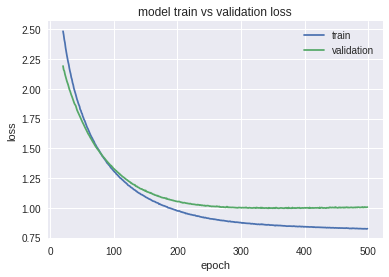

In [0]:
show_error(hist_Deep_AE_concate, 20)

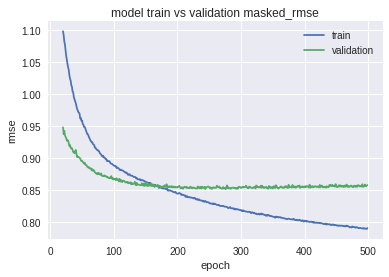

In [0]:
show_rmse(hist_Deep_AE_concate, 20)

In [0]:
plot_model(Deep_AE_concate, to_file='model.png')

In [0]:
test_result_deep = Deep_AE_user.evaluate([users_items_matrix_train_zero, userIDs], users_items_matrix_test)

6040/6040 [==============================] - 1s 145us/sample - loss: 0.9974 - masked_rmse_clip: 0.8582


## Other Experiments

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda67b21630>,
      dtype=object)

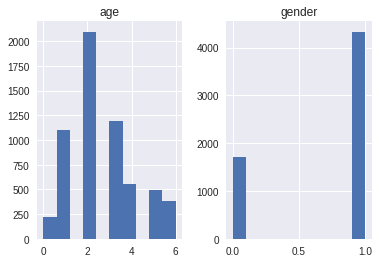

In [0]:
user_df.hist(column=['age', 'gender'])

In [0]:
#Concatenate the one hot encoding side information to the rating matrix
user_items_user_validate_info = np.concatenate((users_items_matrix_validate, onehot_df), axis=1)

In [0]:
train_male_two = user_items_user_info[(user_items_user_info[:, 3953]==1) & (user_items_user_info[:, 3956]==1)]
validate_male_two = user_items_user_validate_info[(user_items_user_validate_info[:, 3953]==1) & (user_items_user_validate_info[:, 3956]==1)]

In [0]:
validate_male_two.shape

(1538, 3982)

In [0]:
 validate_male_two[:, :3952].shape

(1538, 3952)

In [0]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.002
regularizer_decode = 0.002
# Build model
Deep_AE_concate = Deep_AE_model(train_male_two[:, :3952], layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_concate.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate.summary()
hist_Deep_AE_concate = Deep_AE_concate.fit(x=train_male_two[:, :3952], y=train_male_two[:, :3952],
                  epochs=500,
                  batch_size=256,
                  validation_data=[train_male_two[:, :3952], validate_male_two[:, :3952]], verbose=2)

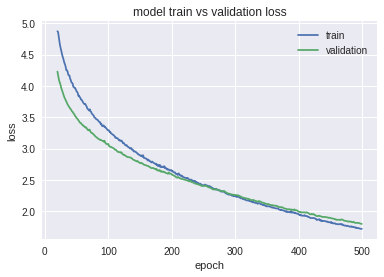

In [125]:
show_error(hist_Deep_AE_concate, 20)

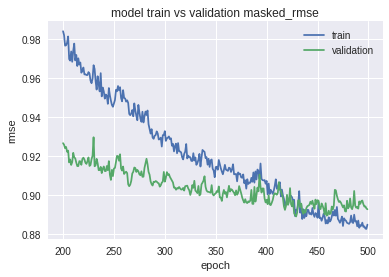

In [126]:
show_rmse(hist_Deep_AE_concate, 200)